In [15]:
!pip install en_core_web_sm

ERROR: Could not find a version that satisfies the requirement en_core_web_sm (from versions: none)
ERROR: No matching distribution found for en_core_web_sm


In [1]:
import pandas as pd


In [2]:

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'

os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'
os.environ["TF_CPP_MIN_VLOG_LEVEL"] = "2"

In [3]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
!pip install --upgrade intel-extension-for-tensorflow[xpu]

In [22]:
!pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/5a/f2/5c2f878c62c8b79c629b11b33516bb55054d7677eba6f56f3a20296b56bd/tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Obtaining dependency information for flatbuffers>=23.1.21 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Obtaining dependency information for grpcio<2.0,>=1.24.3 from https://files.pythonhosted.org/packages/28/fa/c38a010d3fffcac07ef121abb34eb2c3db0876df74267ce5bde13c3a6ed7/grpcio-1.57.0-cp310-cp310-manylinux_2_17_x86_64.manylin

  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.5.0-py2.py3-none-any.whl (83 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
Using cached tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (524.1 MB)
Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
Using cached grpcio-1.57.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 3.8 MB/s eta 0:00:00m eta 0:00:010:01:01
Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl (22.9 MB)
Using cached protobuf-4.24.0-cp37-abi3-manylinux2014_x86_64.whl (311 kB)
Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl (440 kB)
Using cached tensorflow_io_gcs_filesystem-0.33.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
Using cached google_auth-2.22.0-py2.py3-none-any.whl (181 kB)
Using cached 

In [4]:
#importing data
data_su = pd.read_csv("Suicide_Detection.csv")
data_su.drop("Unnamed: 0",inplace=True,axis=1)
data_su.head(10)

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
5,Honetly idkI dont know what im even doing here...,suicide
6,[Trigger warning] Excuse for self inflicted bu...,suicide
7,It ends tonight.I can’t do it anymore. \nI quit.,suicide
8,"Everyone wants to be ""edgy"" and it's making me...",non-suicide
9,My life is over at 20 years oldHello all. I am...,suicide


In [20]:
data_su.shape

(232074, 2)

In [5]:
import re
import spacy
import numpy as np
import pandas as pd
import en_core_web_sm
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from spacy.lang.en.stop_words import STOP_WORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
nlp = en_core_web_sm.load()
lemmatizer = WordNetLemmatizer()
stopwords = STOP_WORDS
EMOJI_PATTERN = re.compile(
    "["
    u"U0001F600-U0001F64F"  # emoticons
    u"U0001F300-U0001F5FF"  # symbols & pictographs
    u"U0001F680-U0001F6FF"  # transport & map symbols
    u"U0001F1E0-U0001F1FF"  # flags (iOS)
    u"U00002702-U000027B0"
    u"U000024C2-U0001F251"
    "]+", flags=re.UNICODE
)
FILTERS = '!"#$%&()*+,-/:;?@[\]^_`{|}~tn'
HTML_TAG_PATTERN = re.compile(r']*>')
NUMBERING_PATTERN = re.compile('d+(?:st|[nr]d|th)')
DISABLE_PIPELINES = ["tok2vec", "parser", "ner", "textcat", "custom", "lemmatizer"]

2023-08-12 09:00:27.634053: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-12 09:00:27.669966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 09:00:28.312886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-12 09:00:28.668604: I itex/core/wrapper/itex_cpu_wrapper.cc:52] Intel Extension for Tensorflow* AVX2 CPU backend is loaded.
2023-08-12 09:00:28.671259: W itex/core/wrapper/itex_gpu_wrapper.cc:32] Could not load dynamic library: libze_loader.so.1: cannot open sha

In [6]:
def initial_preprocessing(text):
    tag_removed_text = HTML_TAG_PATTERN.sub('', text)
    emoji_removed_text = EMOJI_PATTERN.sub(r'', tag_removed_text)
    numberings_removed_text =  NUMBERING_PATTERN.sub('', emoji_removed_text)

    extra_chars_removed_text = re.sub(

        r"(.)1{2,}",  r'11', numberings_removed_text

    )

    return extra_chars_removed_text



In [7]:

def preprocess_text(doc):
    tokens = [

        token

        for token in doc

        if not token.is_space and

           not token.like_email and

           not token.like_url and

           not token.is_stop and

           not token.is_punct and

           not token.like_num

    ]
    translation_table = str.maketrans('', '', FILTERS)

    translated_tokens = [

        token.text.lower().translate(translation_table)

        for token in tokens

    ]

    lemmatized_tokens = [

        lemmatizer.lemmatize(token)

        for token in translated_tokens

        if len(token) > 1

    ]

    return lemmatized_tokens



In [8]:
data_su['class'].unique()

array(['suicide', 'non-suicide'], dtype=object)

In [9]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/isyum/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
labels = data_su['class'].iloc[:10000]

labels = labels.map(lambda x: 1 if x=='non-suicide' else 0)

data = data_su.iloc[:10000, :]

column = 'text'

not_null_data = data[data[column].notnull()]

not_null_data[column] = not_null_data[column].apply(initial_preprocessing)

texts = [
    preprocess_text(doc)
    for doc in nlp.pipe(not_null_data[column], disable=DISABLE_PIPELINES)
]

In [11]:
texts[0]

['wife',
 'hreaeig',
 'uicideecely',
 'lef',
 'wife',
 'good',
 'cheaed',
 'wice',
 'lied',
 'decided',
 'refuse',
 'day',
 'ago',
 'bega',
 'hreaeig',
 'suicide',
 'irelessly',
 'spe',
 'paa',
 'day',
 'alkig',
 'keep',
 'hesiaig',
 'wa',
 'believe',
 'come',
 'kow',
 'lo',
 'people',
 'hreae',
 'order',
 'way',
 'happes',
 'supposed',
 'hadle',
 'deah',
 'hads',
 'love',
 'wife',
 'deal',
 'geig',
 'cheaed',
 'cosaly',
 'feelig',
 'isecure',
 'worried',
 'oday',
 'day',
 'hope',
 'happe']

In [12]:
tokenizer = Tokenizer(
    filters=FILTERS,
    lower=True
)
padding = 'post'
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1
sequences = []
max_sequence_len = 0
for text in texts:
    # convert texts to sequence
    txt_to_seq = tokenizer.texts_to_sequences([text])[0]
    sequences.append(txt_to_seq)
    # find max_sequence_len for padding
    txt_to_seq_len = len(txt_to_seq)
    if txt_to_seq_len > max_sequence_len:
        max_sequence_len = txt_to_seq_len
# post padding
print(max_sequence_len)
padded_sequences = pad_sequences(
    sequences, 
    maxlen=max_sequence_len, 
    padding=padding
)

1505


In [13]:
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_sequence_len))
model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
adam = Adam(learning_rate=0.01)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer=adam, 
    metrics=['accuracy']
)
model.summary()

2023-08-12 09:01:14.064940: E itex/core/wrapper/itex_gpu_wrapper.cc:49] Could not load Intel Extension for Tensorflow* GPU backend, GPU will not be used.
If you need help, create an issue at https://github.com/intel/intel-extension-for-tensorflow/issues
2023-08-12 09:01:14.069096: E itex/core/wrapper/itex_gpu_wrapper.cc:49] Could not load Intel Extension for Tensorflow* GPU backend, GPU will not be used.
If you need help, create an issue at https://github.com/intel/intel-extension-for-tensorflow/issues
2023-08-12 09:01:14.371048: E itex/core/wrapper/itex_gpu_wrapper.cc:49] Could not load Intel Extension for Tensorflow* GPU backend, GPU will not be used.
If you need help, create an issue at https://github.com/intel/intel-extension-for-tensorflow/issues


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1505, 64)          1691776   
                                                                 
 bidirectional (Bidirection  (None, 1505, 128)         66048     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1505, 128)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

2023-08-12 09:01:14.896983: E itex/core/wrapper/itex_gpu_wrapper.cc:49] Could not load Intel Extension for Tensorflow* GPU backend, GPU will not be used.
If you need help, create an issue at https://github.com/intel/intel-extension-for-tensorflow/issues


In [17]:
history = model.fit(
    padded_sequences, 
    labels.values, 
    epochs=2,
    verbose=1,
    batch_size=90
)

Epoch 1/2


2023-08-12 09:03:18.014851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-12 09:03:18.019063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-12 09:03:18.024625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


112/112 [==============================] - 900s 8s/step - loss: 0.3153 - accuracy: 0.8767
Epoch 2/2
112/112 [==============================] - 1041s 9s/step - loss: 0.1442 - accuracy: 0.9516


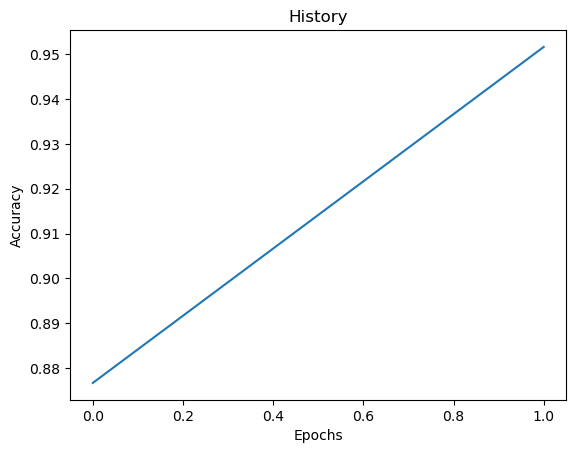

In [18]:
import matplotlib.pyplot as plt
fig = plt.plot(history.history['accuracy'])
title = plt.title("History")
xlabel = plt.xlabel("Epochs")
ylabel = plt.ylabel("Accuracy")

In [ ]:
data_su.head(7)

In [ ]:

def predict (model,txt):
    length = len(txt)
    ini_txt = list(map(initial_preprocessing,txt))

    texts = [
        preprocess_text(doc)
        for doc in nlp.pipe(ini_txt, disable=DISABLE_PIPELINES)
    ]
    tokenizer = Tokenizer(
        filters=FILTERS,
        lower=True
    )
    new_data_seq = tokenizer.texts_to_sequences(texts)
    
    # padding
    new_data_seq_padded = pad_sequences(new_data_seq, maxlen=1505)
    
    
    predictions = model.predict(new_data_seq_padded)
    print(predictions)

In [ ]:
def return_mental_state(val):
    if val > 0.5:
        return("Not-Suicide")
    return ("Suicide")

In [ ]:
#custom testing
txt = ["what am I living for", "I am so happy", "what happede to that guy was sad"]

preds = predict(pickled_model,txt)


In [ ]:
import pickle

In [ ]:
pickle.dump(model, open('model.pkl', 'wb'))
pickel.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [ ]:
pickled_model = pickle.load(open('model.pkl', 'rb'))